
# Trabajo Final
Análisis Matemático para Inteligencia Artificial

Integrantes:
Javier Gonzalo Etcheto (a1901)
Marcelo Alejandro Le Mehaute (a1903)
Jose Luis Perez Galindo (i0907)
Gustavo Ramoscelli (a1908)

# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)

### Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Estructura del código

## Modelo

In [77]:
import numpy as np
from numpy.linalg import det, inv
from time import time

In [78]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    #self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?
    # Esto se hace con names. En y_hat tengo indices, que son los indices necesarios para recuperar nombres en names.
    # De hecho, en names tengo nombres e índices. Podría usar "names" para transform y detransform (esto es lo que estoy haciendo)


  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?
    # Recupera la forma original de arr luego de aplicar la función f a cada elemento  

  # La podría hacer privada para evitar que se invoque de afuera sin haber invocado a fit previamente
  def transform(self, y):
    #return self._map_reshape(lambda name: self.name_to_class[name], y) # No uso name_to_class!
    return  self._map_reshape(lambda name: np.where(self.names == name)[0][0], y) # Acá np.where() devuleve (array([idx]),)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)


  # Puede pasar lo mismo que en tranform si no se llama a fit primero (no existe self.names)
  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [79]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size # Calcula frecuencia de cada clase
    # Q3: para que sirve bincount?
    # Cuenta las ocurrencias de cada valor entero no negativo de y y devuelve un array
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()
    # Method to estimate parameters, to be implemented in each child class based on the specific model.

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)

    # self._fit_params(X, y) # Eliminar esta linea, es sólo para probar Q4. Claramente rompe todo!

    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1] # m_obs es igual a la cantidad de datos que se predicen
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt) # Array de cadenas vacías, en principio. El tamano maximo de las cadenas
    # está definido por fmt

    # Recorre todos las observaciones buscando el máximo
    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]
    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]
    
    # Defino atributos nuevos para analizar resultados
    self.log_posteriori = log_posteriori
    self.log_verosimilitud = [self._predict_log_conditional (x, idx) for idx in range(len(self.log_a_priori))]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [80]:
class QDA(BaseBayesianClassifier):

  # Estimo matrices de covarianza y medias
  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x
  

In [81]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means # Forma (classes, p, 1)
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        self.inner_prod = inner_prod # Forma (classes, 1, 1)

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()
    
    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [82]:
class fasterQDA(TensorizedQDA):
    def _predict_log_conditionals(self, X):

        classes = len(self.log_a_priori)
        n = len(X[1])

        # Forma de X: (p, n)
        # Forma de self.tensor_means: (classes, p, 1)

        X_expanded = np.expand_dims(X, axis=0)  # Forma (1, p, n)
        X_expanded = np.tile(X_expanded, (classes, 1, 1))  # Forma (classes, p, n)

        tensor_means_expanded = np.tile(self.tensor_means, (1, 1, n)) # Forma (classes, p, n)

        unbiased_X = X_expanded - tensor_means_expanded # Forma (classes, p, n)

        unbiased_X_transposed =  unbiased_X.transpose(0,2,1) # Forma (classes, n, p)

        # Forma de self.tensor_inv_cov: (classes, p, p)
        # "classes" matrices de nxn
        inner_prod_mat = unbiased_X_transposed @ self.tensor_inv_cov @ unbiased_X # Forma (classes, n, n)

        dets = np.linalg.det(self.tensor_inv_cov)  # Forma (classes,)
        dets_expanded = np.expand_dims(dets, axis=1)  # Forma (classes, 1)
        dets_expanded = np.tile(dets_expanded, (1, n))  # Forma (classes, n)

        return 0.5 * np.log(dets_expanded) - 0.5 * np.diagonal(inner_prod_mat, axis1=1, axis2=2) # Forma (classes, n)
    
    def _predict_one(self, X):
        # return the class that has maximum a posteriori probability
        n = len(X[1])
        log_a_priori_expanded = np.expand_dims(self.log_a_priori, axis=1)  # Forma (classes, 1)
        log_a_priori_expanded = np.tile(log_a_priori_expanded, (1, n))  # Forma (classes, n)

        self.log_a_posteriori = log_a_priori_expanded + self._predict_log_conditionals(X)

        return np.argmax(self.log_a_posteriori, axis=0)
    
    def predict(self, X):
        prediction_expanded = np.expand_dims(self._predict_one(X), axis=0) # Expando a la forma [self._predict_one(X)]
        # Convierto los indices de la predicción a nombres de clases (con detransform)
        return self.encoder.detransform(prediction_expanded)

In [83]:
class FasterQDA(TensorizedQDA):
    def _predict_log_conditionals(self, X):

        classes = len(self.log_a_priori)
        n = len(X[1])

        # Forma de X: (p, n)
        # Forma de self.tensor_means: (classes, p, 1)

        X_expanded = np.expand_dims(X, axis=0)  # Forma (1, p, n)
        X_expanded = np.tile(X_expanded, (classes, 1, 1))  # Forma (classes, p, n)

        tensor_means_expanded = np.tile(self.tensor_means, (1, 1, n)) # Forma (classes, p, n)

        unbiased_X = X_expanded - tensor_means_expanded # Forma (classes, p, n)

        # Forma de self.tensor_inv_cov: (classes, p, p)
        unbiased_X_transposed =  unbiased_X.transpose(0,2,1) # Forma (classes, n, p)
        A = unbiased_X_transposed @ self.tensor_inv_cov # Forma (classes, n, p)

        # Siguiendo el enunciado, hago np.sum(A * B_tansposed, axis = 1), donde B es unbiesed_x
        inner_prod = (A * unbiased_X_transposed).sum(axis=-1)  # Forma (classes, n)

        dets = np.linalg.det(self.tensor_inv_cov)  # Forma (classes,)
        dets_expanded = np.expand_dims(dets, axis=1)  # Forma (classes, 1)
        dets_expanded = np.tile(dets_expanded, (1, n))  # Forma (classes, n)

        return 0.5 * np.log(dets_expanded) - 0.5 * inner_prod # Forma (classes, n)

    def _predict_one(self, X):
        # return the class that has maximum a posteriori probability
        n = len(X[1])
        log_a_priori_expanded = np.expand_dims(self.log_a_priori, axis=1)  # Forma (classes, 1)
        log_a_priori_expanded = np.tile(log_a_priori_expanded, (1, n))  # Forma (classes, n)

        self.log_a_posteriori = log_a_priori_expanded + self._predict_log_conditionals(X)

        return np.argmax(self.log_a_posteriori, axis=0)
    
    def predict(self, X):
        prediction_expanded = np.expand_dims(self._predict_one(X), axis=0) # Expando a la forma [self._predict_one(X)]
        # Convierto los indices de la predicción a nombres de clases (con detransform)
        return self.encoder.detransform(prediction_expanded)


In [84]:
class LDA(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    # estimate each covariance matrix
    covs =  [(np.cov(X[:,y.flatten()==idx], bias=True)) for idx in range(len(self.log_a_priori))]
    log_a_priori = self.log_a_priori
    self.inv_covs =  [inv(sum([val * mat for val, mat in zip(np.exp(log_a_priori), covs)]))]
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[0]
    modified_x =  x - 0.5*self.means[class_idx] # Ver nombre! Esto es (x-0.5 muj)
    return self.means[class_idx].T @ inv_cov @ modified_x

In [85]:
class TensorizedLDA(LDA):
  def _fit_params(self, X, y):
    # ask plain QDA to fit params
    super()._fit_params(X,y)

    # stack onto new dimension
    self.tensor_inv_cov = np.stack(self.inv_covs)
    self.tensor_means = np.stack(self.means)

  def _predict_log_conditionals(self, x):
    modified_x =  x - 0.5*self.tensor_means
    result = self.tensor_means.transpose(0,2,1) @ self.tensor_inv_cov @ modified_x
    return result.flatten()

  def _predict_one(self, x):
      # return the class that has maximum a posteriori probability
      return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [86]:
class FasterLDA(TensorizedLDA):
    def _predict_log_conditionals(self, X):

        classes = len(self.log_a_priori)
        n = len(X[1])

        X_expanded = np.expand_dims(X, axis=0)  # Forma (1, p, n)
        X_expanded = np.tile(X_expanded, (classes, 1, 1))  # Forma (classes, p, n)

        tensor_means_expanded = np.tile(self.tensor_means, (1, 1, n)) # Forma (classes, p, n)
        modified_X = X_expanded - 0.5*tensor_means_expanded # Forma (classes, p, n)

        #return self.tensor_means.transpose(0,2,1) @ self.tensor_inv_cov @ modified_X # Más directo pero un poco más lento que de la siguiente forma.

        # Repitiendo lo hecho en FasterQDA()
        modified_X_transposed =  modified_X.transpose(0,2,1) # Forma (classes, n, p)
        tensor_means_expanded_transposed = tensor_means_expanded.transpose(0,2,1)
        A = tensor_means_expanded_transposed @ self.tensor_inv_cov  # Forma (classes, n, p)

        return (A * modified_X_transposed).sum(axis=-1) # Forma (3, n)

    def _predict_one(self, X):
        # return the class that has maximum a posteriori probability
        n = len(X[1])
        log_a_priori_expanded = np.expand_dims(self.log_a_priori, axis=1)  # Forma (3, 1)
        log_a_priori_expanded = np.tile(log_a_priori_expanded, (1, n))  # Forma (3, n)

        self.log_a_posteriori = log_a_priori_expanded + self._predict_log_conditionals(X)

        return np.argmax(self.log_a_posteriori, axis=0)
    
    def predict(self, X):
        prediction_expanded = np.expand_dims(self._predict_one(X), axis=0) # Expando a la forma [self._predict_one(X)]
        # Convierto los indices de la predicción a nombres de clases (con detransform)
        return self.encoder.detransform(prediction_expanded)

## Código para pruebas

Seteamos los datos

In [87]:
# hiperparámetros
rng_seed = 6543

In [88]:
from sklearn.datasets import load_iris, fetch_openml

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto') 
    # Vector con las etiquetas, que en este caso corresponden a las especies de pinguinos, asociadas a cada fila del DataFrame df

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

# showing for iris
X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [89]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [90]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

Separamos el dataset en train y test para medir performance

In [91]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sz, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 90) (1, 90) (4, 60) (1, 60)


In [92]:
from sklearn.datasets import load_iris
import pandas as pd

# Cargar el dataset Iris
iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data['target'] = iris.target

# Ver distribución de clases
print(data['target'].value_counts())


target
0    50
1    50
2    50
Name: count, dtype: int64


Entrenamos un QDA y medimos su accuracy

In [93]:
qda = QDA()
lda = LDA()

qda.fit(train_x, train_y)
lda.fit(train_x, train_y)


In [94]:
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


Con el magic %%timeit podemos estimar el tiempo que tarda en correr una celda en base a varias ejecuciones. Por poner un ejemplo, acá vamos a estimar lo que tarda un ciclo completo de QDA y también su inferencia (predicción).

Ojo! a veces [puede ser necesario ejecutarlo varias veces](https://stackoverflow.com/questions/10994405/python-timeit-results-cached-instead-of-calculated) para obtener resultados consistentes.

Si quieren explorar otros métodos de medición también es válido!

In [95]:
%%timeit

qda.predict(test_x)

7.52 ms ± 562 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
%%timeit

model = QDA()
model.fit(train_x, train_y)
model.predict(test_x)

8.88 ms ± 592 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Consigna


## Implementación base
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.

# Resolución

## Ejercicio 1 y 2

En el siguiente código, comente la línea correspondiente para realizar el ejercicio 1 o 2.

La clasificación entre una clase y otra depende de dos términos: $\log\hat{f}_j(x) + \log\hat{\pi}_j$. Para una predicción específica, la elección de una clase sobre otra, cuando el primer término es fijo (ya que depende del conjunto de entrenamiento y de la observación a predecir, siendo esta igual para todas las clases), puede definirse en función del valor del logaritmo de la probabilidad a priori (básicamente la proporción de cada clase conocida de antemano).

En particular, para un problema dado, ambos términos tienen un peso relativo, y el valor del logaritmo de la probabilidad a priori puede ser decisivo al determinar si una observación pertenece a una clase u otra. Es posible, además, que conjuntos diferentes de probabilidades condicionales produzcan las mismas predicciones.

En determinadas comparaciones, cuando la diferencia entre los logaritmos de la verosimilitud entre clases no es suficientemente grande, la probabilidad a priori puede inclinar la balanza a favor de una clase. Por otro lado, si la diferencia entre los logartimos de las verosimilitudes para las distintas clases es significativa, el logaritmo de la probabilidad a priori pierde relevancia y no resulta decisivo.

En el ejemplo de las flores, cambiar la probabilidad a priori de $[1/3, 1/3, 1/3]$ a $[0.9, 0.05, 0.05]$ (asociado a las clases [*setosa*, *versicolor*, *virginica*]) no afecta las decisiones del clasificador, como lo demuestra la precisión obtenida en el código. Esto ocurre porque se mantiene la relación de probabilidades a priori entre las flores con características menos diferenciadas, es decir, *versicolor* y *virginica*, lo que implica que el clasificador no muestra preferencia por una de estas clases sobre la otra. Al comparar estas clases de flores con la clase *setosa*, puede verse que este cambio particular en las probabilidades a priori no altera el resultado debido al "peso" considerable del logaritmo de la verosimilitud de esta última clase. **En todos los casos analizados, la clase con la máxima probabilidad a posteriori coincide con la que presenta la máxima verosimilitud.**

En contraste, si las probabilidades a priori cambian para clases con características más parecidas, por ejemplo, pasar de $[0.05, 0.9, 0.05]$ a $[0.05, 0.05, 0.9]$ (o de $[1/3, 1/3, 1/3]$ a $[0.05, 0.9, 0.05]$ o a $[0.05, 0.05, 0.9]$) sí puede afectar las predicciones. En este caso, el logaritmo de las probabilidades a priori influye en las decisiones del clasificador para ciertas observaciones específicas. Por este motivo, la precisión de la predicción sobre el set de prueba varía entre un caso y otro.

En el caso de los pingüinos, las dos clases con características más parecidas son *Adelie* y *Chinstrap*. Considerar diferentes probabilidades a priori para ambas (por ejemplo, una con una probabilidad de $0.9$ y la otra de $0.05$) puede llevar a que el clasificador escoja, para algunas observaciones particulares, un tipo que no coincide con el real, o al menos con el que el clasificador habría seleccionado si las probabilidades a priori entre estas clases fueran diferentes.

En este ejercicio en particular, mantener la probabilidad a priori relativa entre las clases más parecidas sin cambios, es decir, pasar de la probabilidad a priori $[1/3, 1/3, 1/3]$ a $[0.05, 0.05, 0.9]$ (asociado a las clases [*Adelie*, *Chinstrap*, *Gentoo*]), no afecta la precisión de las predicciones.

Para este analisis se consideraron `n_runs` ejecuciones y un **split** aleatorio para cada una de ellas.

In [97]:
# Comentar la linea correspondiente para ejercicio 1 o 2.
#X_full, y_full = get_iris_dataset() # Ejercicio 1
X_full, y_full = get_penguins() # Ejercicio 2

# Defino un modelo para cada probabilidad a priori
qda_priori_1, priori_1 = QDA(), np.array([1/3, 1/3, 1/3])
qda_priori_2, priori_2 = QDA(), np.array([0.9, 0.05, 0.05])
qda_priori_3, priori_3 = QDA(), np.array([0.05, 0.9, 0.05])
qda_priori_4, priori_4 = QDA(), np.array([0.05, 0.05, 0.9])

# Número de ejecuciones aleatorias
n_runs = 40

# Defino listas que uso spara informar resultados
list_acc_1 = []
list_acc_2 = []
list_acc_3 = []
list_acc_4 = []

list_log_verosimilitud = [[], [], []]

# Ejecutar múltiples corridas
for run in range(n_runs):
    # Dividir los datos de forma aleatoria
    train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, random_state=None)
    #train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, random_state=rng_seed)

    train_x = X_full.T
    train_y = y_full.T
    test_x = X_full.T
    test_y = y_full.T

    qda_priori_1.fit(train_x, train_y, priori_1)
    qda_priori_2.fit(train_x, train_y, priori_2)
    qda_priori_3.fit(train_x, train_y, priori_3)
    qda_priori_4.fit(train_x, train_y, priori_4)

    list_acc_1.append(accuracy(test_y, qda_priori_1.predict(test_x)))
    list_acc_2.append(accuracy(test_y, qda_priori_2.predict(test_x)))
    list_acc_3.append(accuracy(test_y, qda_priori_3.predict(test_x)))
    list_acc_4.append(accuracy(test_y, qda_priori_4.predict(test_x)))

    log_verosimilitud = qda_priori_1.log_verosimilitud
    for idx, val in enumerate(log_verosimilitud):
        list_log_verosimilitud[idx].append(val[0][0])


print("Precisión con priori = [1/3, 1/3, 1/3]: {:.5f}".format(np.mean(list_acc_1)))
print("Precisión con priori = [0.9, 0.05, 0.05]: {:.5f}".format(np.mean(list_acc_2)))
print("Precisión con priori = [0.05, 0.9, 0.05]: {:.5f}".format(np.mean(list_acc_3)))
print("Precisión con priori = [0.05, 0.05, 0.9]: {:.5f}".format(np.mean(list_acc_4)))

print("-------------------------")
print("priori = [1/3, 1/3, 1/3]")
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_1.encoder.names[0], np.mean(list_log_verosimilitud[0]), np.mean(list_log_verosimilitud[0]) + np.log(priori_1[0])))
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_1.encoder.names[1], np.mean(list_log_verosimilitud[1]), np.mean(list_log_verosimilitud[1]) + np.log(priori_1[1])))
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_1.encoder.names[2], np.mean(list_log_verosimilitud[2]), np.mean(list_log_verosimilitud[2]) + np.log(priori_1[2])))

print("priori = [0.9, 0.05, 0.05]")
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_2.encoder.names[0], np.mean(list_log_verosimilitud[0]), np.mean(list_log_verosimilitud[0]) + np.log(priori_2[0])))
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_2.encoder.names[1], np.mean(list_log_verosimilitud[1]), np.mean(list_log_verosimilitud[1]) + np.log(priori_2[1])))
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_2.encoder.names[2], np.mean(list_log_verosimilitud[2]), np.mean(list_log_verosimilitud[2]) + np.log(priori_2[2])))

print("priori = [0.05, 0.9, 0.05]")
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_3.encoder.names[0], np.mean(list_log_verosimilitud[0]), np.mean(list_log_verosimilitud[0]) + np.log(priori_3[0])))
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_3.encoder.names[1], np.mean(list_log_verosimilitud[1]), np.mean(list_log_verosimilitud[1]) + np.log(priori_3[1])))
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_3.encoder.names[2], np.mean(list_log_verosimilitud[2]), np.mean(list_log_verosimilitud[2]) + np.log(priori_3[2])))

print("priori = [0.05, 0.05, 0.9]")
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_4.encoder.names[0], np.mean(list_log_verosimilitud[0]), np.mean(list_log_verosimilitud[0]) + np.log(priori_4[0])))
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_4.encoder.names[1], np.mean(list_log_verosimilitud[1]), np.mean(list_log_verosimilitud[1]) + np.log(priori_4[1])))
print("Clase {} - log verosimilitud, log verosimilitud + log priori: {:.2f}, {:.2f}".format(qda_priori_4.encoder.names[2], np.mean(list_log_verosimilitud[2]), np.mean(list_log_verosimilitud[2]) + np.log(priori_4[2])))

Precisión con priori = [1/3, 1/3, 1/3]: 0.99123
Precisión con priori = [0.9, 0.05, 0.05]: 0.98246
Precisión con priori = [0.05, 0.9, 0.05]: 0.96491
Precisión con priori = [0.05, 0.05, 0.9]: 0.99123
-------------------------
priori = [1/3, 1/3, 1/3]
Clase Adelie - log verosimilitud, log verosimilitud + log priori: -34.43, -35.53
Clase Chinstrap - log verosimilitud, log verosimilitud + log priori: -36.63, -37.73
Clase Gentoo - log verosimilitud, log verosimilitud + log priori: -11.26, -12.36
priori = [0.9, 0.05, 0.05]
Clase Adelie - log verosimilitud, log verosimilitud + log priori: -34.43, -34.54
Clase Chinstrap - log verosimilitud, log verosimilitud + log priori: -36.63, -39.63
Clase Gentoo - log verosimilitud, log verosimilitud + log priori: -11.26, -14.25
priori = [0.05, 0.9, 0.05]
Clase Adelie - log verosimilitud, log verosimilitud + log priori: -34.43, -37.43
Clase Chinstrap - log verosimilitud, log verosimilitud + log priori: -36.63, -36.74
Clase Gentoo - log verosimilitud, log ve

Calculo algunas métricas más (de sklearn). Uso el mismo bucle *for* que en la celda anterior. **Este análisis es sólo para intentar inferir más características del comportamiento del modelo en base a las diferentes probaiblidades a priori.** 

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Comentar la linea correspondiente para ejercicio 1 o 2.
X_full, y_full = get_iris_dataset() # Ejercicio 1
#X_full, y_full = get_penguins() # Ejercicio 2

# Defino un modelo para cada probabilidad a priori
qda_priori_1, priori_1 = QDA(), np.array([1/3, 1/3, 1/3])
qda_priori_2, priori_2 = QDA(), np.array([0.9, 0.05, 0.05])
qda_priori_3, priori_3 = QDA(), np.array([0.05, 0.9, 0.05])
qda_priori_4, priori_4 = QDA(), np.array([0.05, 0.05, 0.9])

# Número de ejecuciones aleatorias
n_runs = 40

# Defino listas que uso spara informar resultados
list_acc_1, Accuracy_1, Precision_1, Recall_1 = [], [], [], []
list_acc_2, Accuracy_2, Precision_2, Recall_2 = [], [], [], []
list_acc_3, Accuracy_3, Precision_3, Recall_3 = [], [], [], []
list_acc_4, Accuracy_4, Precision_4, Recall_4 = [], [], [], []

list_verosimilitud = [[], [], []]

# Ejecutar múltiples corridas
for run in range(n_runs):
    # Dividir los datos de forma aleatoria
    train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, random_state=None)
    #train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, random_state=rng_seed)
    
    # Estas dos lineas son sólo para evaluar qué sucede si analizamos el rendimiento de los modelos sobre el set completo
    #test_x = X_full.T 
    #test_y = y_full.T

    qda_priori_1.fit(train_x, train_y, priori_1)
    qda_priori_2.fit(train_x, train_y, priori_2)
    qda_priori_3.fit(train_x, train_y, priori_3)
    qda_priori_4.fit(train_x, train_y, priori_4)

    qda_priori_1_predict = qda_priori_1.predict(test_x)
    qda_priori_2_predict = qda_priori_2.predict(test_x)
    qda_priori_3_predict = qda_priori_3.predict(test_x)
    qda_priori_4_predict = qda_priori_4.predict(test_x)

    # Accuracy usando función propia
    list_acc_1.append(accuracy(test_y, qda_priori_1_predict))
    list_acc_2.append(accuracy(test_y, qda_priori_2_predict))
    list_acc_3.append(accuracy(test_y, qda_priori_3_predict))
    list_acc_4.append(accuracy(test_y, qda_priori_4_predict)) 

    # Accuracy usando sklearn
    Accuracy_1.append(accuracy_score(test_y[0], qda_priori_1_predict[0]))
    Accuracy_2.append(accuracy_score(test_y[0], qda_priori_2_predict[0]))
    Accuracy_3.append(accuracy_score(test_y[0], qda_priori_3_predict[0]))
    Accuracy_4.append(accuracy_score(test_y[0], qda_priori_4_predict[0]))

    Precision_1.append(precision_score(test_y[0], qda_priori_1_predict[0], average='macro'))
    Precision_2.append(precision_score(test_y[0], qda_priori_2_predict[0], average='macro'))
    Precision_3.append(precision_score(test_y[0], qda_priori_3_predict[0], average='macro'))
    Precision_4.append(precision_score(test_y[0], qda_priori_4_predict[0], average='macro'))

    Recall_1.append(recall_score(test_y[0], qda_priori_1_predict[0], average='macro'))
    Recall_2.append(recall_score(test_y[0], qda_priori_2_predict[0], average='macro'))
    Recall_3.append(recall_score(test_y[0], qda_priori_3_predict[0], average='macro'))
    Recall_4.append(recall_score(test_y[0], qda_priori_4_predict[0], average='macro'))

print(f"Acc., Acc. (sklearn), Pre. y Rec. con priori = [1/3, 1/3, 1/3]: "
      f"{np.mean(list_acc_1):.5f}, "
      f"{np.mean(Accuracy_1):.5f}, "
      f"{np.mean(Precision_1):.5f}, "
      f"{np.mean(Recall_1):.5f}")

print(f"Acc., Acc. (sklearn), Pre. y Rec. con priori = [0.9, 0.05, 0.05]: "
      f"{np.mean(list_acc_2):.5f}, "
      f"{np.mean(Accuracy_2):.5f}, "
      f"{np.mean(Precision_2):.5f}, "
      f"{np.mean(Recall_2):.5f}")

print(f"Acc., Acc. (sklearn), Pre. y Rec. con priori = [0.05, 0.9, 0.05]: "
      f"{np.mean(list_acc_3):.5f}, "
      f"{np.mean(Accuracy_3):.5f}, "
      f"{np.mean(Precision_3):.5f}, "
      f"{np.mean(Recall_3):.5f}")

print(f"Acc., Acc. (sklearn), Pre. y Rec. con priori = [0.05, 0.05, 0.9]: "
      f"{np.mean(list_acc_4):.5f}, "
      f"{np.mean(Accuracy_4):.5f}, "
      f"{np.mean(Precision_4):.5f}, "
      f"{np.mean(Recall_4):.5f}")


Acc., Acc. (sklearn), Pre. y Rec. con priori = [1/3, 1/3, 1/3]: 0.97278, 0.97278, 0.97368, 0.97262
Acc., Acc. (sklearn), Pre. y Rec. con priori = [0.9, 0.05, 0.05]: 0.97278, 0.97278, 0.97368, 0.97262
Acc., Acc. (sklearn), Pre. y Rec. con priori = [0.05, 0.9, 0.05]: 0.95278, 0.95278, 0.95666, 0.95209
Acc., Acc. (sklearn), Pre. y Rec. con priori = [0.05, 0.05, 0.9]: 0.95667, 0.95667, 0.96225, 0.95518


## Implementación base

3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?

## Ejercicio 3 y 4

In [99]:
#X_full, y_full = get_iris_dataset() # Ejercicio 1
X_full, y_full = get_penguins() # Ejercicio 2


# Defino un modelo para cada probabilidad a priori
priori_arr = np.array([[1/3, 1/3, 1/3], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
qda = QDA()
lda = LDA()

# Número de corridas aleatorias
n_runs = 50

# Defino listas que uso spara informar resultados
list_test_acc_qda = []
list_test_acc_lda = []

# Ejecutar múltiples corridas

for priori in priori_arr:
    for run in range(n_runs):
        # Dividir los datos de forma aleatoria
        train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, random_state=None)
        #train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, random_state=rng_seed)

        qda.fit(train_x, train_y, priori)
        lda.fit(train_x, train_y, priori)

        list_test_acc_qda.append(accuracy(test_y, qda.predict(test_x)))
        list_test_acc_lda.append(accuracy(test_y, lda.predict(test_x)))

    print("Priori:", priori)
    print("QDA acc: {:.4f} (std: {:.4f})".format(np.mean(list_test_acc_qda), np.std(list_test_acc_qda)))
    print("LDA acc: {:.4f} (std: {:.4f})".format(np.mean(list_test_acc_lda), np.std(list_test_acc_lda)))

Priori: [0.33333333 0.33333333 0.33333333]
QDA acc: 0.9918 (std: 0.0079)
LDA acc: 0.9920 (std: 0.0079)
Priori: [0.05 0.9  0.05]
QDA acc: 0.9781 (std: 0.0219)
LDA acc: 0.9749 (std: 0.0234)
Priori: [0.05 0.05 0.9 ]
QDA acc: 0.9816 (std: 0.0192)
LDA acc: 0.9806 (std: 0.0213)


Principales resultados: 

<center>

Prior: [0.333333, 0.333333, 0.333333]

Modelo | Accuracy | Std |
:---: | :---: | :---: |
QDA | 0.9886  | 0.0069 |
LDA | 0.9901 | 0.0056 |

Prior: [0.05, 0.9, 0.05]

Modelo | Accuracy | Std |
:---: | :---: | :---: |
QDA | 0.9715  | 0.0255 |
LDA | 0.9666 | 0.0295 |

Prior: [0.05, 0.05, 0.9]

Modelo | Accuracy | Std |
:---: | :---: | :---: |
QDA | 0.9770  | 0.0227 |
LDA | 0.9751 | 0.0272 |

</center>

 * Alta precisión en ambos modelos.
 * Variaciones mínimas en las distribuciónes para las diferentes prioridades a priori consideradas.
 * Basado en los resultados (considerando `n_runs` ejecuciones) y utilizando tres probabilidades a priori diferentes (para tener un análisis más completo), no se puede afirmar de manera concluyente que un modelo sea mejor que otro.

<center>
</center>

## Implementación base
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?

**Sugerencia:** puede resultar de utilidad para cada inciso de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>

## Ejercicio 5

In [100]:
from time import time

#X_full, y_full = get_iris_dataset() # Ejercicio 1
X_full, y_full = get_penguins() # Ejercicio 2

# Defino un modelo para cada probabilidad a priori
priori_arr = np.array([[1/3, 1/3, 1/3], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
qda = QDA()
qda_T = TensorizedQDA()

# Número de corridas aleatorias
n_runs = 100

# Defino listas que uso spara informar resultados
list_test_acc_qda = []
list_test_acc_qda_T = []
list_test_time_qda = []
list_test_time_qda_T = []

# Ejecutar múltiples corridas

for priori in priori_arr[:1]:
    for run in range(n_runs):
        # Dividir los datos de forma aleatoria
        train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, random_state=None)
        #train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, random_state=rng_seed)

        qda.fit(train_x, train_y, priori)
        qda_T.fit(train_x, train_y, priori)

        # Calcular tiempo y guardar en listas
        start_time = time()
        list_test_acc_qda.append(accuracy(test_y, qda.predict(test_x)))
        list_test_time_qda.append(time() - start_time)

        start_time = time()
        list_test_acc_qda_T.append(accuracy(test_y, qda_T.predict(test_x)))
        list_test_time_qda_T.append(time() - start_time)

    print("QDA acc: {:.3f} (std: {:.3f})".format(np.mean(list_test_acc_qda), np.std(list_test_acc_qda)))
    print("Tensorized QDA acc: {:.3f} (std: {:.3f})".format(np.mean(list_test_acc_qda_T), np.std(list_test_acc_qda_T)))

    print("QDA time: {:.4f} (std: {:.4f})".format(np.mean(list_test_time_qda), np.std(list_test_time_qda)))
    print("Tensorized QDA time: {:.4f} (std: {:.4f})".format(np.mean(list_test_time_qda_T), np.std(list_test_time_qda_T)))


QDA acc: 0.988 (std: 0.009)
Tensorized QDA acc: 0.988 (std: 0.009)
QDA time: 0.0486 (std: 0.0076)
Tensorized QDA time: 0.0105 (std: 0.0034)


Principales resultados:

<center>

Modelo | Accuracy | std (acc) | Tiempo | std (t) |
:---: | :---: | :---: | :---: | :---: | 
QDA | 0.988  | 0.009 | 0.0189 | 0.0116 | 
Tensorized QDA | 0.988 | 0.009 | 0.0038 | 0.0024 |

</center>

 * Ambos modelos mantienen la misma precisión
 * TQDA es más rápido


## Optimización matemática

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4.Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5.Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

## Optimización matemática - Resolución

In [101]:
X_full, y_full = get_iris_dataset() 

# Defino un modelo para cada probabilidad a priori
priori = [1/3, 1/3, 1/3]
qda = QDA()
qda_T = TensorizedQDA()
qda_f = fasterQDA()
qda_F = FasterQDA()
lda = LDA()
lda_T = TensorizedLDA()
lda_F = FasterLDA()

# Número de corridas aleatorias
n_runs = 1000

# Defino listas que uso para informar resultados
list_test_acc_qda = []
list_test_acc_qda_T = []
list_test_acc_qda_f = []
list_test_acc_qda_F = []
list_test_acc_lda = []
list_test_acc_lda_T = []
list_test_acc_lda_F = []

list_test_time_qda = []
list_test_time_qda_T = []
list_test_time_qda_f = []
list_test_time_qda_F = []
list_test_time_lda = []
list_test_time_lda_T = []
list_test_time_lda_F = []

# Ejecutar múltiples corridas


for run in range(n_runs):
    # Dividir los datos de forma aleatoria
    train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, random_state=None)

    # test_x = X_full.T # Para analizar performance en tiempo
    # test_y = y_full.T # Para analizar performance en tiempo
    

    qda.fit(train_x, train_y, priori)
    qda_T.fit(train_x, train_y, priori)
    qda_f.fit(train_x, train_y, priori)
    qda_F.fit(train_x, train_y, priori)
    lda.fit(train_x, train_y, priori)
    lda_T.fit(train_x, train_y, priori)
    lda_F.fit(train_x, train_y, priori)

    # Calcular tiempo y guardar en listas
    start_time = time()
    list_test_acc_qda.append(accuracy(test_y, qda.predict(test_x)))
    list_test_time_qda.append(time() - start_time)

    start_time = time()
    list_test_acc_qda_T.append(accuracy(test_y, qda_T.predict(test_x)))
    list_test_time_qda_T.append(time() - start_time)

    start_time = time()
    list_test_acc_qda_f.append(accuracy(test_y, qda_f.predict(test_x)))
    list_test_time_qda_f.append(time() - start_time)

    start_time = time()
    list_test_acc_qda_F.append(accuracy(test_y, qda_F.predict(test_x)))
    list_test_time_qda_F.append(time() - start_time)

    start_time = time()
    list_test_acc_lda.append(accuracy(test_y, lda.predict(test_x)))
    list_test_time_lda.append(time() - start_time)

    start_time = time()
    list_test_acc_lda_T.append(accuracy(test_y, lda_T.predict(test_x)))
    list_test_time_lda_T.append(time() - start_time)

    start_time = time()
    list_test_acc_lda_F.append(accuracy(test_y, lda_F.predict(test_x)))
    list_test_time_lda_F.append(time() - start_time)


print("QDA acc: {:.3f} (std: {:.3f})".format(np.mean(list_test_acc_qda), np.std(list_test_acc_qda)))
print("Tensorized QDA acc: {:.3f} (std: {:.3f})".format(np.mean(list_test_acc_qda_T), np.std(list_test_acc_qda_T)))
print("faster QDA acc: {:.3f} (std: {:.3f})".format(np.mean(list_test_acc_qda_f), np.std(list_test_acc_qda_f))) # Pasando por la matriz nxn (en realidad por el tensor classes x nxn)
print("Faster QDA acc: {:.3f} (std: {:.3f})".format(np.mean(list_test_acc_qda_F), np.std(list_test_acc_qda_F)))
print("LDA acc: {:.3f} (std: {:.3f})".format(np.mean(list_test_acc_lda), np.std(list_test_acc_lda)))
print("Tensorized LDA acc: {:.3f} (std: {:.3f})".format(np.mean(list_test_acc_lda_T), np.std(list_test_acc_lda_T)))
print("Faster LDA acc: {:.3f} (std: {:.3f})".format(np.mean(list_test_acc_lda_F), np.std(list_test_acc_lda_F)))

print("QDA time: {:.5f} (std: {:.5f})".format(np.mean(list_test_time_qda), np.std(list_test_time_qda)))
print("Tensorized QDA time: {:.5f} (std: {:.5f})".format(np.mean(list_test_time_qda_T), np.std(list_test_time_qda_T)))
print("faster QDA time: {:.5f} (std: {:.5f})".format(np.mean(list_test_time_qda_f), np.std(list_test_time_qda_f)))
print("Faster QDA time: {:.5f} (std: {:.5f})".format(np.mean(list_test_time_qda_F), np.std(list_test_time_qda_F)))
print("LDA time: {:.5f} (std: {:.5f})".format(np.mean(list_test_time_lda), np.std(list_test_time_lda)))
print("Tensorized LDA time: {:.5f} (std: {:.5f})".format(np.mean(list_test_time_lda_T), np.std(list_test_time_lda_T)))
print("Faster LDA time: {:.5f} (std: {:.5f})".format(np.mean(list_test_time_lda_F), np.std(list_test_time_lda_F)))

QDA acc: 0.973 (std: 0.022)
Tensorized QDA acc: 0.973 (std: 0.022)
faster QDA acc: 0.973 (std: 0.022)
Faster QDA acc: 0.973 (std: 0.022)
LDA acc: 0.978 (std: 0.019)
Tensorized LDA acc: 0.978 (std: 0.019)
Faster LDA acc: 0.978 (std: 0.019)
QDA time: 0.01863 (std: 0.00474)
Tensorized QDA time: 0.00420 (std: 0.00235)
faster QDA time: 0.00066 (std: 0.00151)
Faster QDA time: 0.00052 (std: 0.00129)
LDA time: 0.00910 (std: 0.00331)
Tensorized LDA time: 0.00276 (std: 0.00230)
Faster LDA time: 0.00048 (std: 0.00129)


**Respuestas**
1. En la clase `QDA` (y `TensorizedQDA`), se utiliza un ciclo `for` para recorrer el set a predecir, elemento a elemento. Para cada observación de este set, el método `predict(X)` invoca, para cada elemento del dataset, al método privado `_predict_one(x)` (que a su vez invoca a `_predict_log_conditional(x)`). En particular, para `QDA`, el método `_predict_one(x)` utiliza un ciclo `for` que recorre cada una de las clases (de flores, por ejemplo), mientras que `TensorizedQDA`, lo realiza en una sola pasada cara cada observación particular.  Por medio de tensores, es posible mejorar esta última implementación, de forma de eliminar el ciclo `for` de `predict(X)`.

Acá, el set a predecir es $X \in \mathbb{R}^{p \times n}$. Luego, en la implementación, se expande a un tensor $X_{\text{expanded}} \in \mathbb{R}^{clases \times p \times n}$ (en este caso, básicamente un tensor formado por 3 matrices de observaciones). Esto permite que las operaciones se lleven a cabo sin utilizar ciclos.

A su vez, los promedios están guardados en $\text{tensor\_means} \in \mathbb{R}^{clases \times p \times 1}$, que tambien se expande para tener la dimensión del tensor $X_{\text{expanded}}$ (para poder operar).

Se calcula el tensor de $\text{unbiased\_X}$ y su versión transpuesta. Con esto, y con el tensor de las matrices de covarianzas invertidas, se puede calcular el producto interno necesario para hallar el logaritmo de la verosimilitud (en particular, el término $- \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)$). Este producto interno es un tensor de matrices ($n \times n$). 

En el código, esta linea es: 

`inner_prod_mat = unbiased_X_transposed @ self.tensor_inv_cov @ unbiased_X # Forma (classes, n, n)`

Dado que lo que interesa es unicamente la diagonal de las matrices de los productos internos, se aplica el método `np.dagonal()`. Con esto se reduce el orden de los tensores ($clases \times n$)). Para ser consistente con las operaciones y tener un resultado matricial, se calcula el determinante de la matriz de covarianza invertida para cada clase y se lo *broadcastea* a los $n$ elementos del set. Con esto se puede calcular el término faltante para el logaritmo de la verosimilitud, es decir, $\frac{1}{2} \log{|\Sigma_j^{-1}|}$. Esto resulta en una verosimilitud por observación para cada tipo de clase, o lo que es lo mismo, una matriz de $clases \times n$).

Luego, por medio del método `predict(X)` de esta `class`, que a su vez invoca a `_predict_one(X)` se puede obtener la predicción final en una sola pasado, dado que ambos métodos utilizan matrices.

2. A este método, que pasa por las matrices de $n \times n$, se lo llama `fasterQDA`. A continuación puede verse el resultado comparativo de `QDA` (sin usar tensores y con dos ciclos `for`, uno para las clases y el otro para los elementos del set), `TensorizedQDA` (utiliza tensores pero pasa por un ciclo `for` para predecir) y `fasterQDA`. El tiempo se expresa en segundos (set de test, con split de 0.3).

 - QDA time: 0.00242 (std: 0.00055)

 - Tensorized QDA time: 0.00062 (std: 0.00051)

 - faster QDA time: 0.00010 (std: 0.00030)

Evidentemente se logran aceleraciones muy altas al pasar de uno a otro. 

4. Por construcción, los elementos de la diagonal de $A \cdot B$ están dados por $diag(A \cdot B)_i = \sum_{j=1}^{p} a_{ij} \cdot b_{ji}$, donde $i$ es el índice de la diagonal.

Además, $(A \odot B^T)_{ij} = a_{ij} \cdot b_{ji}$. Por lo tanto, por comparación, podemos ver que sumando sobre el índice $j$, desde $1$ hasta $p$ (columnas de $A \odot B^T$), obtenemos que $\sum_{col}(A \odot B^T)_i = \sum_{j=1}^{p} a_{ij} \cdot b_{ij} = diag(A \cdot B)_i$.

Con esto se ve que $diag(A \cdot B) = \sum_{col}(A \odot B^T)$.

Su implementación en **Python**, usando un **NumPy-Array**, donde una matriz se construye como un arreglo de vectores filas, es:
$$
\text{np.sum}(A \odot B^T, \text{axis}=1)
$$
En este caso, $\text{axis}=1$ representa el segundo eje de la matriz, es decir, se suma sobre cada elemento (columna) de las filas de la misma.

5. Las diferencias en tiempos encontradas son (set de test, con split de 0.3):

 - faster QDA time: 0.00010 s (std: 0.00030 s)
 - Faster QDA time: 0.00008 s (std: 0.00027 s)

Diferencias en las implementaciones: 

 - `fasterQDA`:

`unbiased_X_transposed =  unbiased_X.transpose(0,2,1) # Forma (classes, n, p)`

`inner_prod_mat = unbiased_X_transposed @ self.tensor_inv_cov @ unbiased_X # Forma (classes, n, n)`

Multiplico $classes = 3$ matrices de $ n \times p$ por $classes = 3$ de $p \times p$, y luego mutiplico por $classes = 3$ matrices de $ p \times n$. 

Costo en operaciones matemáticas (multipliaciones): 
 - Primera multiplicación (omitiendo $classes$): $n \times p^2$
 - Segunda multiplicación (omitiendo $classes$): $n^2 \times p$

 - Total: $classes \times (n \times p^2 + n^2 \times p)$

 - `FasterQDA`:
 
`unbiased_X_transposed =  unbiased_X.transpose(0,2,1) # Forma (classes, n, p)`

`A = unbiased_X_transposed @ self.tensor_inv_cov # Forma (classes, n, p)`

`inner_prod = (A * unbiased_X_transposed).sum(axis=-1)  # Forma (classes, n)`

Multiplico $classes = 3$ matrices de $ n \times p$ por $classes = 3$ de $p \times p$, y luego a esto lo multiplico elemento a elemento por $classes = 3$ matrices de la misma dimensión ($n \times p$).

Costo en operaciones matemáticas (multipliaciones): 
 - Primera multiplicación (omitiendo $classes$): $n \times p^2$
 - Segunda multiplicación elemento a elemento (omitiendo $classes$): $n \times p$

 - Total: $classes \times (n \times p^2 + n \times p)$

 Si se tiene en cuenta únicamente el cósto matemátcio de estas lineas de código (las que determinan si se trata de una u otra implemntación), puede verse que la relación entre ellos es $\frac{classes \times (n \times p^2 + n^2 \times p)}{classes \times (n \times p^2 + n \times p)}$. Considerando el set de test con $n = 45$, $p = 4$, esta relación nos da $\approx 10$. Es decir, en base a esto sería esperable que `FasterQDA` sea $10$ veces más rápido que `fasterQDA` (suponiendo que el tiempo de cómputo y el número de operaciones es proporcional, aunque en la práctica depende de la arquitectura de hardware, optimizaciones de las bibliotecas, etc). Evidentemente, el costo total tiene en cuenta operaciones adicionales, tales como broadcasting, sumas, transposiciones, multiplicaciones, la búsqueda de los máximos (con `np.maxarg()`), etc. Esto hace que la relación entre el número de operaciones, y por lo tanto consumo de tiempo (que es otra métrica) entre las implementaciones, sea menor (sumamos las mismas cantidades en el numerador y el denominador, lo cual reduce la relación).

 Además, de la relación mostrada, se ve que aumentando el $n$ (datos a predecir) la relación en el costo matemático debería aumentar. Esto efectivamente ocurre. Por ejemplo, los tiempos de predicción (de nuevo, no es la misma métrica que la de operaciones matemáticas, pero debería ser una buen indicador) considerando el set completo $\text{X\_full}$ son:

 - faster QDA time: 0.00019 s (std: 0.00039 s)
 - Faster QDA time: 0.00011 s (std: 0.00032 s)

En resumen, al evitar el paso por la matriz $n \times n$, `FasterQDA` logra speedup significativ. Aunque el límite teórico (si la complejidad de la predicción dependiera sólo del cálculo del producto interno) muestra un speedup de $\frac{n^2 \times p}{n \times p^2} = \frac{n}{p}$ para $n \gg p$ (teniendo en cuenta la relación de costos mostrada), en la práctica, el costo adicional de otras operaciones reduce este speedup, pero hay que notar que el mismo sigue siendo considerable. El speedup alcanzado en estas implementaciones puede verse a continuación:

<img src="speedup_vs_n.png" alt="Gráfico de Speedup vs. n" width="1000">


In [102]:
# Descomentar para evaluar. Demora varios minutos para ejecutarse.
'''
import matplotlib.pyplot as plt

# Variables para almacenar tamaños y aceleración
sizes = []
accelerations = []

# Incrementar tamaño del conjunto de prueba
test_x = X_full.T
for i in range(0, 100):  # 100 pasos para aumentar el tamaño de test_x
    test_x = np.hstack([test_x, X_full.T])  # Ampliar concatenando
    sizes.append(test_x.shape[1])

    # Variables para almacenar tiempos de las 10 ejecuciones
    time_FasterQDA_list = []
    time_fasterQDA_list = []

    # Ejecutar 20 veces y almacenar tiempos
    for _ in range(20):
        # Medir tiempo de FasterQDA
        start_time = time()
        qda_F.predict(test_x)
        time_FasterQDA_list.append(time() - start_time)

        # Medir tiempo de fasterQDA
        start_time = time()
        qda_f.predict(test_x)
        time_fasterQDA_list.append(time() - start_time)

    # Promedio de tiempos
    time_FasterQDA_avg = np.mean(time_FasterQDA_list)
    time_fasterQDA_avg = np.mean(time_fasterQDA_list)

    acceleration = time_fasterQDA_avg / time_FasterQDA_avg

    accelerations.append(acceleration)
'''


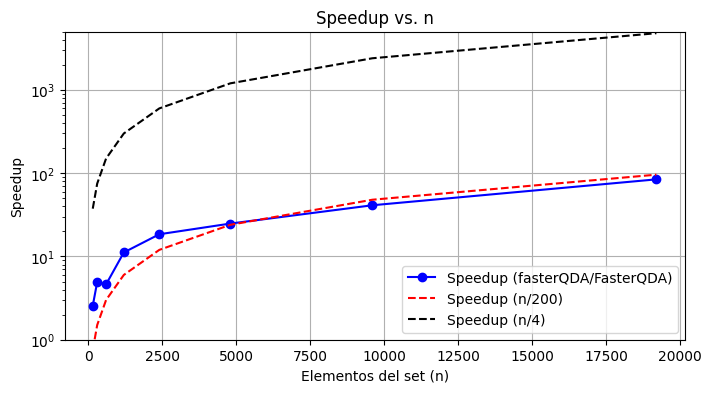

In [123]:
# Descomentar para generar gráfico del speedup
'''
# Escalamiento teórico calculado n/p. Dado a que es mayor, uso uno más chico n/100
scaling_theoretical_100 = np.array(sizes) / 200
scaling_theoretical_4 = np.array(sizes) / 4

# Graficar resultados
plt.figure(figsize=(8, 4))
plt.plot(sizes, accelerations, label="Speedup (fasterQDA/FasterQDA)", marker="o", color="b")
plt.plot(sizes, scaling_theoretical_100, label="Speedup (n/200)", linestyle="--", color="r")
plt.plot(sizes, scaling_theoretical_4, label="Speedup (n/4)", linestyle="--", color="black")
plt.ylim(1, 5000)
plt.yscale('log')
plt.xlabel("Elementos del set (n)")
plt.ylabel("Speedup")
plt.title("Speedup vs. n")
plt.legend()
plt.grid(True)
plt.savefig("speedup_vs_n.png", dpi=300)
plt.show()
'''

## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.
2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".
3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?



1. Partimos de la expresión general para el logaritmo de la función de densidad de probabilidad condicional:

$$\log{f_j(x)} = -\frac{1}{2} \log{|\Sigma|} - \frac{1}{2} (x - \mu_j)^T \Sigma^{-1} (x - \mu_j) + C$$

Donde $\Sigma$ es la matriz de covarianza común a todas las clases en LDA.

Entonces, los pasos para llegar a la expresión final son los siguientes:

Expandimos el término cuadrático:
$$(x - \mu_j)^T \Sigma^{-1} (x - \mu_j) = x^T \Sigma^{-1} x - x^T \Sigma^{-1} \mu_j - \mu_j^T \Sigma^{-1} x + \mu_j^T \Sigma^{-1} \mu_j$$

Simplificamos, notando que $x^T \Sigma^{-1} \mu_j$ es un escalar y por lo tanto igual a su transpuesta:
$$= x^T \Sigma^{-1} x - 2 \mu_j^T \Sigma^{-1} x + \mu_j^T \Sigma^{-1} \mu_j$$

Sustituimos esto en la expresión original:
$$\log{f_j(x)} = -\frac{1}{2} \log{|\Sigma|} - \frac{1}{2} (x^T \Sigma^{-1} x - 2 \mu_j^T \Sigma^{-1} x + \mu_j^T \Sigma^{-1} \mu_j) + C$$

Distribuimos el $-\frac{1}{2}$:
$$ -\frac{1}{2} \log{|\Sigma|} - \frac{1}{2} x^T \Sigma^{-1} x + \mu_j^T \Sigma^{-1} x - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C$$

Agrupamos los términos que no dependen de j en una nueva constante C':
$$ \mu_j^T \Sigma^{-1} x - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C'$$

Factorizamos $\mu_j^T \Sigma^{-1}$:
$$ \mu_j^T \Sigma^{-1} (x - \frac{1}{2} \mu_j) + C'$$

Así llegamos a la expresión final:
$$ \log{f_j(x)} = \mu_j^T \Sigma^{-1} (x - \frac{1}{2} \mu_j) + C'$$

2. En QDA, la función a maximizar es:
$$ \log{f_j(x)} = -\frac{1}{2} \log{|\Sigma_j|} - \frac{1}{2} (x - \mu_j)^T \Sigma_j^{-1} (x - \mu_j) + C$$

Al expandir el término cuadrático, obtenemos términos de segundo orden en x $(x^T \Sigma_j^{-1} x)$.
- Estos términos cuadráticos resultan en límites de decisión cuadráticos en el espacio de características.
- La superficie de decisión entre dos clases será una función cuadrática de x.

En LDA, la función a maximizar se simplifica a:
$$\log{f_j(x)} = \mu_j^T \Sigma^{-1} (x - \frac{1}{2} \mu_j) + C'$$
- Esta expresión es lineal en x, ya que solo contiene términos de primer orden en x.
- No hay términos cuadráticos en x.
- La superficie de decisión entre dos clases será una función lineal de x, resultando en límites de decisión lineales en el espacio de características.

3. La implementación de QDA usa:
`0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x`

Mientras que la expresión teórica es:
$$-\frac{1}{2} \log{|\Sigma_j|} - \frac{1}{2} (x - \mu_j)^T \Sigma_j^{-1} (x - \mu_j)$$

Diferencias y equivalencias:
- Uso de la inversa de la covarianza: La implementación usa inv_cov directamente. Esto es equivalente porque $\det(\Sigma_j^{-1}) = 1 / \det(\Sigma_j)$.

- Signo del término logarítmico: La implementación usa `0.5*np.log(det(inv_cov)) en lugar de $-\frac{1}{2} \log{|\Sigma_j|}$. Esto es equivalente debido a la propiedad del logaritmo: $\log{(1/x)} = -\log{(x)}$.

- Cálculo del término cuadrático: La implementación usa `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x`, donde `unbiased_x` = $(x - \mu_j)$ Esto es algebraicamente igual a decir que: $(x - \mu_j)^T \Sigma_j^{-1} (x - \mu_j)$.

- La implementación no incluye una constante aditiva.
Esto no afecta la clasificación, ya que la constante es la misma para todas las clases y no influye en la comparación de probabilidades. Las expresiones son matemáticamente equivalentes, con la implementación utilizando algunas propiedades algebraicas para simplificar el cálculo.

## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

### Parámetros iniciales

- Pesos de la primera capa:
  $$
  w^{(1)} = \begin{pmatrix}
  0.1 & -0.5 \\
  -0.3 & -0.9 \\
  0.8 & 0.02
  \end{pmatrix}
  $$

- Sesgos de la primera capa:
  $$
  b^{(1)} = \begin{pmatrix}
  0.1 \\
  0.5 \\
  0.8
  \end{pmatrix}
  $$

- Pesos de la segunda capa:
  $$
  w^{(2)} = \begin{pmatrix}
  -0.4 & 0.2 & -0.5
  \end{pmatrix}
  $$

- Sesgo de la segunda capa:
  $$
  b^{(2)} = 0.7
  $$

### Observación y función de costo

- Entrada:
$$
x = \begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}
$$

- Salida esperada:
$$
y = 5
$$

- Función de costo:
$$
J(\theta) = \frac{1}{2}(\hat{y}_\theta - y)^2
$$

### Paso 1: Forward propagation

1. Cálculo del input para la primera capa:
   $$
   z^{(1)} = w^{(1)} x + b^{(1)}
   $$

   Calculamos cada componente:
   - Para la neurona 1:
     $$
     z_1^{(1)} = (0.1)(1.8) + (-0.5)(-3.4) + 0.1 = 1.98
     $$
   - Para la neurona 2:
     $$
     z_2^{(1)} = (-0.3)(1.8) + (-0.9)(-3.4) + 0.5 = 3.02
     $$
   - Para la neurona 3:
     $$
     z_3^{(1)} = (0.8)(1.8) + (0.02)(-3.4) + 0.8 = 2.192
     $$

2. Aplicar la función de activación (sigmoide):
   $$
   a^{(1)}_i = \sigma(z_i^{(1)})
   $$
   Calculamos las salidas:
   $$ a_1^{(1)} = \sigma(1.98) \approx 0.8787 $$
   $$ a_2^{(1)} = \sigma(3.02) \approx 0.9536 $$
   $$ a_3^{(1)} = \sigma(2.192) \approx 0.8997 $$

3. Cálculo de la función de preactivación:
   $$
   z^{(2)} = w^{(2)} a^{(1)} + b^{(2)}
   $$

   Sustituyendo los valores:
   $$
   z^{(2)} = (-0.4)(a_1^{(1)}) + (0.2)(a_2^{(1)}) + (-0.5)(a_3^{(1)}) + 0.7
   $$
   Calculamos:
   $$
   z^{(2)} \approx -0.3515 + 0.1907 - 0.44985 + 0.7 \approx 0.08905
   $$

4. Salida de la red:
   Aplicamos sigmoide nuevamente:
   $$
   y_{\hat{\theta}} = \sigma(z^{(2)}) \approx 0.52225
   $$

### Paso 2: Cálculo del costo y de las derivadas

Calculamos la función de costo $J(\theta)$ = $\frac{1}{2}(\hat{y}_\theta - y)^2$:

$$
J(\theta) = \frac{1}{2}(0.522577 - 5)^2 \approx 10.0432
$$

La derivada de la función de costo con respecto a la salida es:
$$
\frac{\partial J}{\partial y_{\hat{\theta}}} = y_{\hat{\theta}} - y
$$

Sustituyendo los valores obtenidos:
$$
\frac{\partial J}{\partial y_{\hat{\theta}}} = (0.52225 - 5) \approx -4.47775
$$

### Paso 3: Backpropagation

#### Calculo de la derivada de la función de costo, usando la regla de la cadena

Para los parámetros de la segunda capa:
$$
\frac{\partial J}{\partial w_i^{(2)}} = \frac{\partial J}{\partial \hat{y}_\theta} \frac{\partial \hat{y}_\theta}{\partial w_i^{(2)}} = \frac{\partial J}{\partial \hat{y}_\theta} \frac{\partial \hat{y}_\theta}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial w_i^{(2)}} = \frac{\partial J}{\partial \hat{y}_\theta} \frac{\partial \sigma(z^{(2)})}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial w_i^{(2)}}
$$
$$
\frac{\partial J}{\partial \hat{y}_\theta} = (\hat{y}_\theta - y)
$$
$$
 \frac{\partial \sigma(z^{(l)})}{\partial z^{(l)}} = \frac{\partial}{\partial z^{(l)}}\left( \frac{1}{1+e^{-z^{(l)}}} \right) = \frac{e^{-z^{(l)}}}{(1+e^{-z^{(l)}})^2} = \frac{1(1-1+e^{-z^{(l)}})}{(1+e^{-z^{(l)}})^2} =
$$
$$
= \frac{1}{1+e^{-z^{(2)}}}\frac{1-1+e^{-z^{(2)}}}{1+e^{-z^{(2)}}} = \frac{1}{1+e^{-z^{(2)}}}\left(\frac{1+e^{-z^{(2)}}}{1+e^{-z^{(2)}}}-\frac{1}{1-e^{-z^{(2)}}}\right) =
$$
$$
= \sigma(z^{(2)}) (1-\sigma(z^{(2)}) = \hat{y}_\theta (1-\hat{y}_\theta)
$$
$$
\frac{\partial z^{(2)}}{\partial w_i^{(2)}} = a_i^{(1)}
$$

$$
\frac{\partial J}{\partial w_i^{(2)}} =  (\hat{y}_\theta - y) \hat{y}_\theta (1-\hat{y}_\theta) a_i^{(1)} 
$$

$$
\frac{\partial J}{\partial b^{(2)}} =  \frac{\partial J}{\partial \hat{y}_\theta} \frac{\partial \hat{y}_\theta}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial b^{(2)}}  = (\hat{y}_\theta - y) \hat{y}_\theta (1-\hat{y}_\theta) 
$$

Para los parámetros de la primera capa:

$$
\frac{\partial J}{\partial w_{ij}^{(1)}} = \frac{\partial J}{\partial \hat{y}_\theta} \frac{\partial \hat{y}_\theta}{\partial z^{(2)}} \frac{\partial z_i^{(2)}}{\partial a_i^{(1)}} \frac{\partial a_i^{(1)}}{\partial z_i^{(1)}} \frac{\partial z_i^{(1)}}{\partial w_{ij}^{(1)}} 
$$

$$
\frac{\partial J}{\partial \hat{y}_\theta} = (\hat{y}_\theta - y)
$$

$$
\frac{\partial J}{\partial a^{(2)}} = a^{(2)} - y = 0.522577 - 5 = -4.477423
$$

Luego:
$$
\frac{\partial \hat{y}_\theta}{\partial z^{(2)}} = \frac{\partial \sigma(z^{(2)})}{\partial z^{(2)}} = \hat{y}_\theta (1-\hat{y}_\theta)
$$
$$
\frac{\partial z_i^{(2)}}{\partial a_i^{(1)}} = w_i^{(2)}
$$
$$
\frac{\partial a_i^{(1)}}{\partial z_i^{(1)}} = \frac{\partial \sigma(z_i^{(1)})}{\partial z_i^{(1)}} = \sigma(z_i^{(1)})(1-\sigma(z_i^{(1)})) = a_i^{(1)}(1-a_i^{(1)})
$$
$$
\frac{\partial z_i^{(1)}}{\partial w_{ij}^{(1)}} = a_j^{(0)}
$$

$$
\frac{\partial J}{\partial w_{ij}^{(1)}} = (\hat{y}_\theta - y) \hat{y}_\theta (1-\hat{y}_\theta) w_i^{(2)} a_i^{(1)}(1-a_i^{(1)}) a_j^{(0)}
$$
$$
\frac{\partial J}{\partial b_{i}^{(1)}} = \frac{\partial J}{\partial \hat{y}_\theta} \frac{\partial \hat{y}_\theta}{\partial z^{(2)}} \frac{\partial z_i^{(2)}}{\partial a_i^{(1)}} \frac{\partial a_i^{(1)}}{\partial z_i^{(1)}} \frac{\partial z_i^{(1)}}{\partial b_{i}^{(1)}} = (\hat{y}_\theta - y) \hat{y}_\theta (1-\hat{y}_\theta) w_i^{(2)} a_i^{(1)}(1-a_i^{(1)})
$$

## Cálculo de las derivadas para cada parámetro de la capa de salida

1) Calculamos $\frac{\partial a^{(2)}}{\partial z^{(2)}}$:
   
   $$
   \frac{\partial a^{(2)}}{\partial z^{(2)}} = a^{(2)}(1 - a^{(2)}) = 0.522577(1 - 0.522577) \approx 0.249498
   $$

2) Calculamos $\frac{\partial J}{\partial z^{(2)}}$:
   
   $$
   \frac{\partial J}{\partial z^{(2)}} = \frac{\partial J}{\partial a^{(2)}} \cdot \frac{\partial a^{(2)}}{\partial z^{(2)}} \approx -4.477423 \cdot 0.249498 \approx -1.117106
   $$

3) Entonces, la derivada de $J$ respecto a $w^{(2)}$ es:
   
   $$
   \frac{\partial J}{\partial w^{(2)}} = \frac{\partial J}{\partial z^{(2)}} \cdot a^{(1)}
   $$
   $$
   \frac{\partial J}{\partial w^{(2)}} \approx [-0.981481, -1.064588, -1.002604]
   $$

4) La derivada de $J$ respecto a $b^{(2)}$ es:
   
   $$
   \frac{\partial J}{\partial b^{(2)}} = \frac{\partial J}{\partial z^{(2)}} \approx -1.117106
   $$

5) La derivada de $J$ respecto a $a^{(1)}$ es:
   
   $$
   \frac{\partial J}{\partial a^{(1)}} = \frac{\partial J}{\partial z^{(2)}} \cdot w^{(2)}
   $$
   $$
   \frac{\partial J}{\partial a^{(1)}} \approx [0.446842, -0.223421, 0.558553]
   $$

6) La derivada de $J$ respecto a $z^{(1)}$ es:
   
   $$
   \frac{\partial J}{\partial z^{(1)}} = \frac{\partial J}{\partial a^{(1)}} \cdot \frac{\partial a^{(1)}}{\partial z^{(1)}}
   $$
   $$
   \frac{\partial J}{\partial z^{(1)}} \approx [0.047735, -0.009935, 0.051354]
   $$

7) La derivada de $J$ respecto para $w^{(1)}$ es:
   
   $$
   \frac{\partial J}{\partial w^{(1)}} = \frac{\partial J}{\partial z^{(1)}} \cdot x^T
   $$

   $$
   \frac{\partial J}{\partial w^{(1)}} \approx \begin{bmatrix}
   0.085923 & -0.162299 \\
   -0.017883 & 0.033779 \\
   0.092437 & -0.174604
   \end{bmatrix}
   $$
   
9) La derivada de $J$ respecto a $b^{(1)}$ es:   
   $$
   \frac{\partial J}{\partial b^{(1)}} = \frac{\partial J}{\partial z^{(1)}} \approx [0.047735, -0.009935, 0.051354]
   $$

## Preguntas en el código
Previamente las preguntas "técnicas" en comentarios en el código eran parte del TP, y buscaban que el alumno logre entrar en el detalle de por qué cada linea de código es como es y en el orden en el que está. Ya no forman parte de la consigna, pero se aconseja al alumno intentar responderlas. Las respuestas a las mismas se encuentran en un archivo separado.

### ClassEncoder

Q1: ¿Por qué no hace falta definir un `class_to_name` para el mapeo inverso?
- Porque el mapeo de clase a nombre (`int` a `string`) ya se puede accediendo al índice correspondiente del vector `self.names`.

Q2: ¿Por qué hace falta un `reshape`?
- Porque como **NumPy** no tiene una función que aplique elemento a elemento una función escalar, la aplicación se debe hacer vía una list comprehension sobre el arreglo flatteneado. Al hacer el `flatten` se pierde la dimensionalidad original, por lo que es necesario un `reshape` para recuperarla.

### BaseBayesianClassifier

Q3: ¿Para qué sirve `bincount`?

- Sirve para contar las frecuencias absolutas de aparición de cada clase. Al dividir por `y.size`, se recuperan las frecuencias relativas, que son la estimación de las probabilidades a priori de cada clase.

Q4: ¿Por qué el `_fit_params` va al final? ¿No se puede mover a, por ejemplo, antes de la priori?

Repasemos qué ocurre antes:
- Se encodean las clases para pasarlas a valores numéricos entre $0$ y $k-1$.
- Se obtienen las probabilidades a priori (impuestas o estimadas). Notar que si no se encodean previamente las clases, el `bincount` de `_estimate_a_priori` se rompe.

- El método `_fit_params` requiere que las clases estén encodeadas y utiliza el atributo `self.log_a_priori`, por lo que rompe si alguno de los anteriores no es realizado.

### QDA

Q5: ¿Por qué hace falta el `flatten` y no se puede directamente `X[:,y==idx]`?
- Porque `y` en realidad está modelado como una matriz para poder ser un vector columna, y **NumPy** arroja error si se intenta indexar una dimensión (la de las columnas de $X$) con un array de dos dimensiones, incluso si una de esas dos es de tamaño $1$.

Q6: ¿Por qué se usa `bias=True` en vez del default `bias=False`?
- Porque `bias = True` divide por $n$ en vez de por $n-1$ (insesgada), que es el valor default, y es lo que queremos porque ese es el estimador de máxima verosimilitud.

Q7: ¿Qué hace `axis = 1`? ¿Por qué no $axis = 0`?
- Porque en nuestro esquema de observaciones como vectores columna, los datos se encuentran en formato (features, observaciones), donde una matriz $X$ de dimensiones $(p, n)$ indica que tiene $p$ features y hay $n$ observaciones. Calcular la media sobre las columnas es promediar sobre las observaciones, hacerlo sobre las features ($axis=0$) no tendría sentido.